In [1]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import joblib

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
data_gas = pd.read_excel('Data_Gas_Atlanta_East_Parsed.xlsx', sheet_name='Sheet1')
data_parcel = pd.read_excel('Data_Parcel_Atlanta_East_Parsed.xlsx', sheet_name='Sheet1')

In [3]:
#cols = ['SumOfFLEET Gas', 'SumOfFLEET Parcel', 'SumOfFLEET All', 'tempmax', 'tempmin', 'Category', 'RATE DAY','RATE MILE', 'Utilization Rate All']

cols_gas = ['SumOfFLEET Gas','tempmax', 'tempmin', 'Category', 'RATE DAY','RATE MILE', 'Utilization Rate Gas']

cols_parcel = ['SumOfFLEET Parcel','tempmax', 'tempmin', 'Category', 'RATE DAY','RATE MILE', 'Utilization Rate Parcel']

df_gas = data_gas[cols_gas]

df_parcel = data_parcel[cols_parcel]
#df.loc[:, 'DATE OUT'] = df['DATE OUT'].astype('int64').astype('float64')

print(df_gas.dtypes)

SumOfFLEET Gas            int64
tempmax                 float64
tempmin                 float64
Category                  int64
RATE DAY                float64
RATE MILE               float64
Utilization Rate Gas    float64
dtype: object


In [4]:
#%% train and test sets

features_gas = df_parcel.drop('Utilization Rate Parcel', axis=1)
labels_gas = df_parcel['Utilization Rate Parcel']

# Split the data into training and test sets
train_features_gas, test_features_gas, train_labels_gas, test_labels_gas = train_test_split(features_gas, labels_gas, test_size = 0.20, random_state = 43)

print('Training Features Shape:', train_features_gas.shape)
print('Training Labels Shape:', train_labels_gas.shape)
print('Testing Features Shape:', test_features_gas.shape)
print('Testing Labels Shape:', test_labels_gas.shape)

feature_gas_list = list(features_gas.columns)

Training Features Shape: (2552, 6)
Training Labels Shape: (2552,)
Testing Features Shape: (638, 6)
Testing Labels Shape: (638,)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Initialize the Linear Regression model
lr_gas = LinearRegression()

# Train the model
lr_gas.fit(train_features_gas, train_labels_gas)

# Predict on the test set
pred_lr_gas = lr_gas.predict(test_features_gas)

# Calculate the mean squared error for the Linear Regression model
mse_lr_gas = mean_squared_error(test_labels_gas, pred_lr_gas)
print(f"Linear Regression MSE: {mse_lr_gas}")

# Sorting the coefficients in descending order
sorted_coeffs_gas = sorted(zip(train_features_gas.columns, lr_gas.coef_), key=lambda x: x[1], reverse=True)

# Print the intercept
print("Intercept:", lr_gas.intercept_)

# Print the sorted coefficients for each feature
for feature, coef in sorted_coeffs_gas:
    print(f"{feature}: {coef}")


print('________________________________________________')

Linear Regression MSE: 0.014247314030528467
Intercept: 0.5943676583695644
RATE MILE: 0.01790368365529502
RATE DAY: 0.0019366633468677402
tempmin: 0.00011488470633615525
Category: -1.734723475976807e-18
SumOfFLEET Parcel: -3.5413348302974103e-05
tempmax: -9.009804056408902e-05
________________________________________________


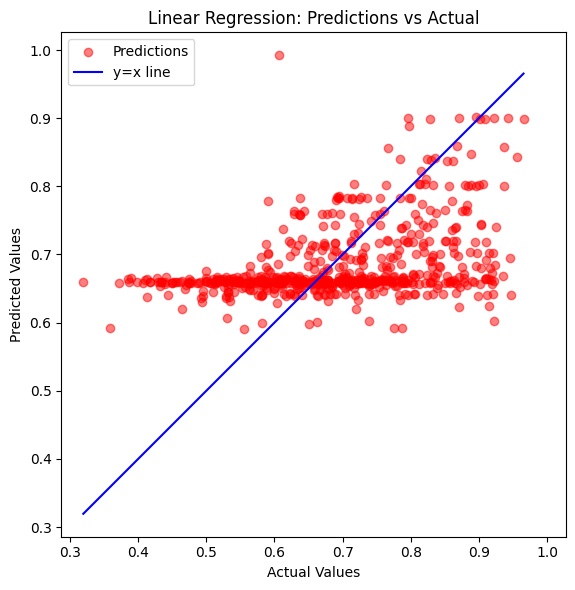

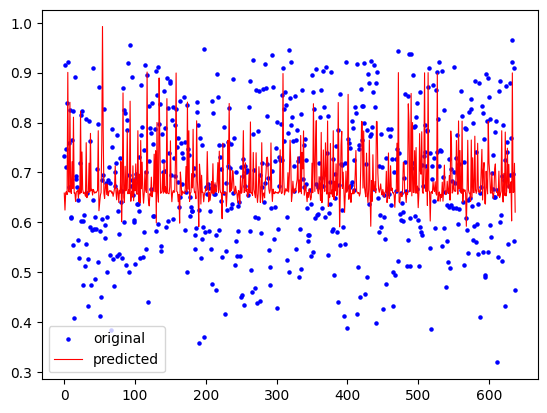

In [6]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_labels_gas, pred_lr_gas, color='red', alpha=0.5, label='Predictions')
plt.plot([min(test_labels_gas), max(test_labels_gas)], [min(test_labels_gas), max(test_labels_gas)], color='blue', label='y=x line')
plt.title('Linear Regression: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('square')

plt.tight_layout()
plt.show()

lr_x_ax = range(len(test_labels_gas))
plt.scatter(lr_x_ax, test_labels_gas, s=5, color="blue", label="original")
plt.plot(lr_x_ax, pred_lr_gas, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [7]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 43)
# Train the model on training data
rf.fit(train_features_gas, train_labels_gas);

# Use the forest's predict method on the test data
rf_pred_gas = rf.predict(test_features_gas)
# Calculate the absolute errors
rf_errors = abs(rf_pred_gas - test_labels_gas)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape_rf = 100 * (rf_errors / test_labels_gas)
mse_rf = mean_squared_error(test_labels_gas, rf_pred_gas)
print(f"RandomForest MSE: {mse_rf}")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape_rf)
print('Accuracy:', round(accuracy, 2), '%.')
from sklearn.metrics import r2_score
score = r2_score(test_labels_gas, rf_pred_gas)
print("The accuracy of our model is {}%".format(round(score, 2) *100))


Mean Absolute Error: 0.08 degrees.
RandomForest MSE: 0.00971312427188406
Accuracy: 88.2 %.
The accuracy of our model is 43.0%


In [8]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.feature_selection import SelectFromModel

# # Create a Random Forest Regressor
# rf = RandomForestRegressor(random_state=43)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 300, 500, 800, 1000],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Randomized search with cross-validation
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, random_state=43, n_jobs=-1)

# # Train the model on training data
# rf_random.fit(train_features_gas, train_labels_gas)

# # Best parameters found
# print("Best Parameters:", rf_random.best_params_)

# # Use the best estimator from the RandomizedSearchCV
# best_rf = rf_random.best_estimator_

# # Predict using the test set
# rf_pred_gas = best_rf.predict(test_features_gas)


In [9]:
# # Fit the model to obtain feature importances
# best_rf.fit(train_features_gas, train_labels_gas)

# # Extract feature importances
# importances = best_rf.feature_importances_

# # Select features based on importance threshold
# threshold = 0.05  # Set your desired threshold
# sfm = SelectFromModel(best_rf, threshold=threshold)
# sfm.fit(train_features_gas, train_labels_gas)

# # Transform the data to select important features
# selected_features = train_features_gas.columns[sfm.get_support()]
# selected_train_features_gas = sfm.transform(train_features_gas)
# selected_test_features_gas = sfm.transform(test_features_gas)

In [10]:
# print("Selected Features:")
# print(train_features_gas.columns[sfm.get_support()])

In [11]:
# best_params = {
#     'n_estimators': 1000,
#     'min_samples_split': 2,
#     'min_samples_leaf': 4,
#     'max_depth': 10
# }
# best_rf_selected = RandomForestRegressor(**best_params, random_state=43)

# # Train the model on the selected features
# best_rf_selected.fit(selected_train_features_gas, train_labels_gas)

# # Predict using the test set with selected features
# rf_pred_selected_gas = best_rf_selected.predict(selected_test_features_gas)

In [12]:
# from sklearn.metrics import mean_squared_error, r2_score

# # Calculate predictions using the model with selected features
# predictions_selected_gas = best_rf_selected.predict(selected_test_features_gas)

# Evaluate the model
# mse_selected = mean_squared_error(test_labels_gas, predictions_selected_gas)
# r2_selected = r2_score(test_labels_gas, predictions_selected_gas)

# print("Mean Squared Error (Selected Features):", mse_selected)
# print("R-squared (Selected Features):", r2_selected)


In [13]:
joblib.dump(rf, "./random_forest.joblib", compress=3)

['./random_forest.joblib']

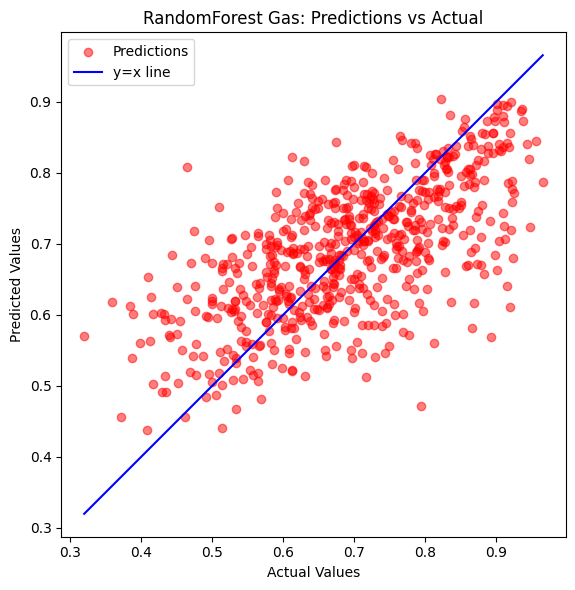

In [14]:
import matplotlib.pyplot as plt

#Random Forest Predictions vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_labels_gas, rf_pred_gas, color='red', alpha=0.5, label='Predictions')
plt.plot([min(test_labels_gas), max(test_labels_gas)], [min(test_labels_gas), max(test_labels_gas)], color='blue', label='y=x line')
plt.title('RandomForest Gas: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('square')

plt.tight_layout()
plt.show()

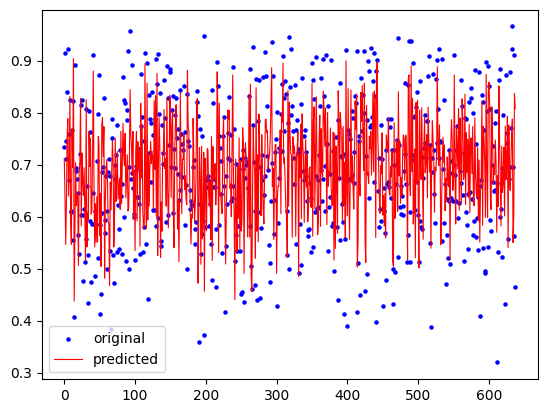

In [15]:
rf_x_ax = range(len(test_labels_gas))
plt.scatter(rf_x_ax, test_labels_gas, s=5, color="blue", label="original")
plt.plot(rf_x_ax, rf_pred_gas, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

MSE: 0.01


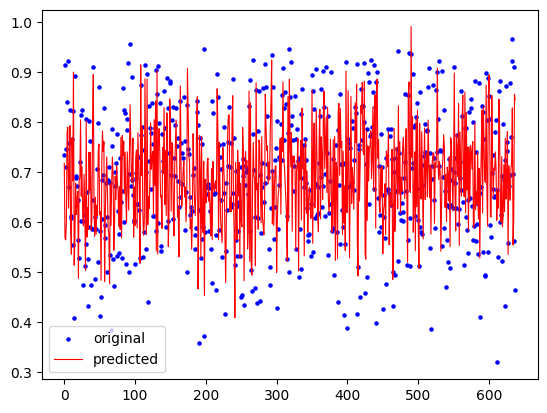

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# with new parameters
gbr = GradientBoostingRegressor(n_estimators=1000, 
    max_depth=8, 
    learning_rate=0.01, 
    min_samples_split=2)
# with default parameters
#gbr = GradientBoostingRegressor()

gbr.fit(train_features_gas, train_labels_gas)

gbr_pred_gas = gbr.predict(test_features_gas)
mse = mean_squared_error(test_labels_gas,gbr_pred_gas)
print("MSE: %.2f" % mse)

gbr_ax = range(len(test_labels_gas))
plt.scatter(gbr_ax, test_labels_gas, s=5, color="blue", label="original")
plt.plot(gbr_ax, gbr_pred_gas, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

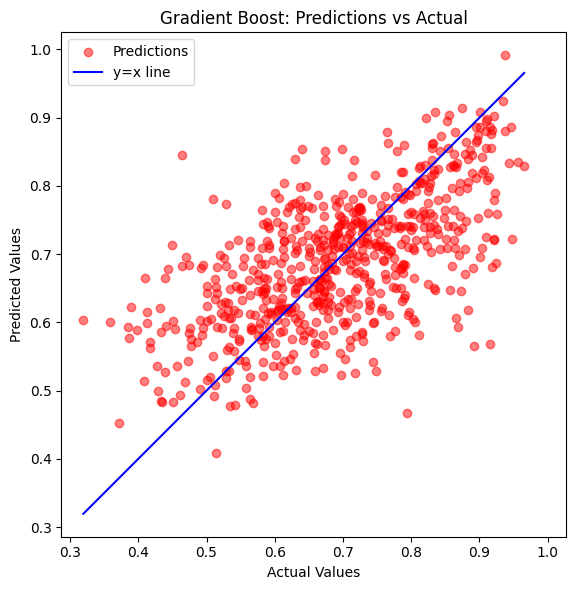

Mean Absolute Error: 0.08 degrees.
The accuracy of our model is 38.0%


In [17]:
import matplotlib.pyplot as plt

#Random Forest Predictions vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_labels_gas, gbr_pred_gas, color='red', alpha=0.5, label='Predictions')
plt.plot([min(test_labels_gas), max(test_labels_gas)], [min(test_labels_gas), max(test_labels_gas)], color='blue', label='y=x line')
plt.title('Gradient Boost: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.axis('square')

plt.tight_layout()
plt.show()

# Calculate the absolute errors
errors = abs(gbr_pred_gas - test_labels_gas)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / gbr_pred_gas)
score_gf = r2_score(test_labels_gas, gbr_pred_gas)
print("The accuracy of our model is {}%".format(round(score_gf, 2) *100))